## 加载数据

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib 
%matplotlib inline
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
# pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [43]:
import json
import pandas as pd
data_file_1 = open("/Users/houdeliao/Desktop/金工资料/FRE-GY 7773/Final Project/yelp_dataset/yelp_academic_dataset_business.json")
data_1 = []
for line in data_file_1:
    data_1.append(json.loads(line))
business = pd.DataFrame(data_1)
data_file_1.close()

## 处理、清洗数据：“yelp_business”

In [44]:
## drop unuseful column 'hours','attributes'
business.drop(['hours','attributes'], axis=1, inplace=True)

## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## 按洲名简写筛选数据，
## 并存入新的dataframe：use
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.4267,-119.7112,5.0000,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.5511,-90.3357,3.0000,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.2232,-110.8805,3.5000,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.9555,-75.1556,4.0000,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.3382,-75.4717,4.5000,13,1,"Brewpubs, Breweries, Food"


In [45]:
usa.isnull().sum()

business_id       0
name              0
address           0
city              0
state             0
postal_code       0
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
categories      102
dtype: int64

In [46]:
usa=usa.dropna(axis=0, subset=['categories'])

In [47]:
## 选出所有餐厅，
## 并存入新的dataframe：us_restaurants
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]

## select out 16 cuisine types of restaurants and rename the category
## 把 us_restaurants['category'] 中含有指定种类的餐厅筛选出来，
## 并新建column：'category'

# us_restaurants.is_copy=False 版本过老
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
us_restaurants[:20]

/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_57618/3096763070.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  us_restaurants['category']=pd.Series()
/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_57618/3096763070.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_restaurants['category']=pd.Series()
/Users/houdeliao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,category
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.9555,-75.1556,4.0000,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",NaN
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.2696,-87.0589,2.0000,6,1,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",NaN
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,"Pubs, Restaurants, Italian, Bars, American (Tr...",Greek
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.2081,-86.7682,1.5000,10,1,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",NaN
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.9553,-82.4563,4.0000,10,1,"Vietnamese, Food, Restaurants, Food Trucks",Vietnamese
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.6371,-86.1272,2.5000,28,1,"American (Traditional), Restaurants, Diners, B...",American
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.9161,-82.7605,4.5000,100,0,"Food, Delis, Italian, Bakeries, Restaurants",Italian
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.9539,-75.1432,4.0000,245,1,"Sushi Bars, Restaurants, Japanese",Japanese
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.9432,-75.1626,4.5000,205,1,"Korean, Restaurants",Korean
22,kfNv-JZpuN6TVNSO6hHdkw,Hibachi Express,6625 E 82nd St,Indianapolis,IN,46250,39.9043,-86.0531,4.0000,20,1,"Steakhouses, Asian Fusion, Restaurants",NaN


In [48]:
## drop null values in category, 
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])

## delete original column categories 
del us_restaurants['categories']

## and reset the index
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.9553,-82.4563,4.0000,10,1,Vietnamese
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.6371,-86.1272,2.5000,28,1,American
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.9161,-82.7605,4.5000,100,0,Italian
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.9539,-75.1432,4.0000,245,1,Japanese
5,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.9432,-75.1626,4.5000,205,1,Korean
6,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.4761,-119.7893,2.5000,339,1,Italian
7,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.1599,-86.7732,4.0000,161,0,Japanese
8,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.9398,-75.1574,4.0000,65,0,Italian
9,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.9626,-75.1357,3.5000,65,1,American


In [49]:
## check whether has duplicated business id（重复id）
us_restaurants.business_id.duplicated().sum()

0

In [50]:
## check the datatype（数据类别）
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
category         object
dtype: object

In [51]:
## check missing values（缺失数据）
us_restaurants.isnull().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
category        0
dtype: int64

## 加载、处理、清洗数据：“yelp_review”

In [52]:
## load review table
# review = pd.read_csv('yelp_review.csv')
# review.head()
import json
import pandas as pd
data_file_2 = open("/Users/houdeliao/Desktop/金工资料/FRE-GY 7773/Final Project/yelp_dataset/yelp_academic_dataset_review.json")
data_2 = []
for line in data_file_2:
    data_2.append(json.loads(line))
review = pd.DataFrame(data_2)
data_file_2.close()

In [53]:
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0000,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0000,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0000,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0000,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0000,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [54]:
## check missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [55]:
## check duplicates of review_id
review.review_id.duplicated().sum()

0

## 合并两个数据集——>得到新数据集 “restaurants_reviews”

In [56]:
## 以 'business_id' 为准合并两个df，得到 “restaurants_reviews”
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')

In [57]:
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,is_open,category,review_id,user_id,stars_y,useful,funny,cool,text,date
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,9fmAJ76g2-CKbbU14Ai1aw,LNprC9Mi8Xqtgk1KCFlKAg,4.0000,0,0,0,"I like Tsevis because they have good gyros, wh...",2014-02-25 22:34:59
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,OCmjANuYad62GAyY0NI8bQ,z-i_Qv-E3qeHfdPZddpwYQ,4.0000,0,0,0,Good Greek American food. I highly recomend th...,2013-01-29 04:27:04
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,QPZ66Xk54CprqZgTW1QTdQ,m6YhwUNoehMm6s52w9A4eA,2.0000,0,0,0,Wife and I have eaten lunch here a few times o...,2013-10-25 15:39:01
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,yUpKEiSWjcix-zWHFMT39w,-YAnRx8VSDkASxlylv3dyg,1.0000,0,0,0,After about 7 minutes of waiting patiently for...,2014-07-16 19:17:34
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,JR0MWE4psJqD2MyHbMckxA,WJ-veSDe63t0HnCu2E1NSA,1.0000,3,0,0,Three of us decided to try this place out last...,2012-12-17 18:37:23


In [58]:
## 更新 column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## 把评论中所有的：特殊符号和换行符 全部用空格替换，然后计算每个评论的字数并存入 'num_words_review'
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

# 根据星级，对评论 label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_57618/29687241.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))


## Review Analysis：准备阶段 -> 举例分析

In [59]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)


## convert text to lower case 全部转化为小写
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation（又重复操作了一遍）
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

restaurants_reviews.head()


/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_57618/3823308358.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')


,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels,removed_punct_text
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,9fmAJ76g2-CKbbU14Ai1aw,LNprC9Mi8Xqtgk1KCFlKAg,4.0000,0,0,0,"i like tsevis because they have good gyros, wh...",2014-02-25 22:34:59,53,positive,i like tsevis because they have good gyros whi...
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,OCmjANuYad62GAyY0NI8bQ,z-i_Qv-E3qeHfdPZddpwYQ,4.0000,0,0,0,good greek american food. i highly recomend th...,2013-01-29 04:27:04,26,positive,good greek american food i highly recomend the...
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,QPZ66Xk54CprqZgTW1QTdQ,m6YhwUNoehMm6s52w9A4eA,2.0000,0,0,0,wife and i have eaten lunch here a few times o...,2013-10-25 15:39:01,184,negative,wife and i have eaten lunch here a few times o...
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,yUpKEiSWjcix-zWHFMT39w,-YAnRx8VSDkASxlylv3dyg,1.0000,0,0,0,after about 7 minutes of waiting patiently for...,2014-07-16 19:17:34,186,negative,after about 7 minutes of waiting patiently for...
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,JR0MWE4psJqD2MyHbMckxA,WJ-veSDe63t0HnCu2E1NSA,1.0000,3,0,0,three of us decided to try this place out last...,2012-12-17 18:37:23,224,negative,three of us decided to try this place out last...


In [60]:
# ## 将 positive file 导入 list：positive_words中
# file_positive = open('/Users/houdeliao/Desktop/positive.txt')
# reader =csv.reader(file_positive)
# positive_words = [word[0] for word in reader]


import sys
positive_words=[]
with open('/Users/houdeliao/Desktop/positive.txt','r') as p:
    for pline in p:
        positive_words.append(pline.strip('\n'))



## 将 negative file 导入 list：negative_words中
file_negative = open('/Users/houdeliao/Desktop/negative_.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]


# negative_words=[]
# with open('/Users/houdeliao/Desktop/negative.txt','r') as n:
#     for nline in n:
#         negative_words.append(nline.strip('\n'))
# print(negative_words)



In [61]:
"""
创立函数
"""
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df


In [62]:
## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words


In [63]:
## 得到重要性评分
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    ## drop unnecessary words
    unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',
                                                   'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous','liked','incredible','outstanding','positive']
    unuseful_negative_words =  ['bad','disappointed','disappointing','horrible','disappoint','lacking','unfortunately','sorry']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score


In [64]:
def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)
    

In [65]:
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df


In [66]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

## For Example Japanese Cuisine

In [67]:
Japanese_reviews = get_dataset('Japanese')
Japanese_train = split_data(Japanese_reviews, 0.9)
print('Total %d number of reviews' % Japanese_train.shape[0])

Total 13683 number of reviews


In [68]:
Japanese_polarity_score = get_polarity_score(Japanese_train)
get_top_words(Japanese_polarity_score, 'positive',20)

/Users/houdeliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score,frequency,polarity
word,,,
delicious,0.6294,2747,0.1264
fresh,0.2012,2726,0.0401
friendly,0.2780,1725,0.0350
recommend,0.1993,1434,0.0209
reasonable,0.5817,351,0.0149
phenomenal,1.1181,141,0.0115
attentive,0.2591,568,0.0108
affordable,0.8697,156,0.0099
solid,0.5900,224,0.0097


In [69]:
get_top_words(Japanese_polarity_score,'negative',20)

,score,frequency,polarity
word,,,
cold,-0.3508,212,-0.0054
expensive,-0.3274,221,-0.0053
bland,-0.6105,72,-0.0032
terrible,-0.9781,44,-0.0031
seasoned,-0.3795,113,-0.0031
wrong,-0.1812,229,-0.0030
slow,-0.2077,189,-0.0029
hard,-0.1185,316,-0.0027
mediocre,-0.9707,36,-0.0026


## 基于SVC表的分类器

In [ ]:
# # 缩小数据集

# def get_half_dataset(category):
#     df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
#     df.reset_index(drop=True, inplace =True)
#     df.rename(columns={'removed_punct_text':'text'}, inplace=True)
#     df_P = df[['text','labels']][df.labels == 'positive']
#     df_N = df[['text','labels']][df.labels == 'negative']
#     df_P = df_P.sample(n=int(len(df_P)/2),random_state=66)
#     df_N = df_N.sample(n=int(len(df_N)/2),random_state=66)
#     frames = [df_P, df_N]
#     result = pd.concat(frames)
#     result.reset_index(drop=True, inplace =True)
#     return result
    

    
# African = get_half_dataset('African')
# Hawaiian = get_half_dataset('Hawaiian')
# Spanish = get_half_dataset('Spanish')
# Korean = get_half_dataset('Korean')
# Greek = get_half_dataset('Greek')
# Indian = get_half_dataset('Indian')
# Mediterranean = get_half_dataset('Mediterranean')
# Vietnamese = get_half_dataset('Vietnamese')
# French = get_half_dataset('French')
# Thai = get_half_dataset('Thai')
# Japanese = get_half_dataset('Japanese')
# Chinese = get_half_dataset('Chinese')
# Italian = get_half_dataset('Italian')
# Mexican = get_half_dataset('Mexican ')
# American = get_half_dataset('American')

# frames = [African,Hawaiian,Spanish,Korean,Greek,Indian,Mediterranean,Vietnamese,French,
#           Thai,Japanese,Chinese,Italian,Mexican,American]
# half_dataset = pd.concat(frames)
# half_dataset.reset_index(drop=True, inplace =True)

# half_dataset


In [ ]:
# American
# 1382459
# Mexican
# 394148
# Italian
# 381091
# Chinese
# 168030
# Japanese
# 149138
# Thai-
# 96494
# French
# 87150
# Vietnamese
# 80229
# Mediterranean
# 79245
# Indian
# 73155
# Greek
# 66667
# Korean
# 52393
# Spanish
# 37273
# Hawaiian
# 22960
# African
# 6831


In [73]:
# 缩小数据集

def get_half_dataset(category,num):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    df_P = df[['text','labels']][df.labels == 'positive']
    df_N = df[['text','labels']][df.labels == 'negative']
    df_P = df_P.sample(n=int(num/2),random_state=66)
    df_N = df_N.sample(n=int(num/2),random_state=66)
    frames = [df_P, df_N]
    result = pd.concat(frames)
    result.reset_index(drop=True, inplace =True)
    return result
    

    
# African = get_half_dataset('African',683)
# Hawaiian = get_half_dataset('Hawaiian',2296)
# Spanish = get_half_dataset('Spanish',3727)
# Korean = get_half_dataset('Korean',5239)
# Greek = get_half_dataset('Greek',6666)
# Indian = get_half_dataset('Indian',7315)
# Mediterranean = get_half_dataset('Mediterranean',7924)
# Vietnamese = get_half_dataset('Vietnamese',8022)
# French = get_half_dataset('French',8715)
# Thai = get_half_dataset('Thai',9649)
# Japanese = get_half_dataset('Japanese',14913)
# Chinese = get_half_dataset('Chinese',16803)
# Italian = get_half_dataset('Italian',38109)
# Mexican = get_half_dataset('Mexican',39414)
# American = get_half_dataset('American',138245)


    
African = get_half_dataset('African',100)
Hawaiian = get_half_dataset('Hawaiian',100)
Spanish = get_half_dataset('Spanish',100)
Korean = get_half_dataset('Korean',100)
Greek = get_half_dataset('Greek',100)
Indian = get_half_dataset('Indian',100)
Mediterranean = get_half_dataset('Mediterranean',100)
Vietnamese = get_half_dataset('Vietnamese',100)
French = get_half_dataset('French',100)
Thai = get_half_dataset('Thai',100)
Japanese = get_half_dataset('Japanese',100)
Chinese = get_half_dataset('Chinese',100)
Italian = get_half_dataset('Italian',100)
Mexican = get_half_dataset('Mexican',100)
American = get_half_dataset('American',100)


frames = [African,Hawaiian,Spanish,Korean,Greek,Indian,Mediterranean,Vietnamese,French,
          Thai,Japanese,Chinese,Italian,Mexican,American]
half_dataset = pd.concat(frames)
half_dataset.reset_index(drop=True, inplace =True)

half_dataset

,text,labels
0,we really love it been there with my wife and ...,positive
1,so happy to have suya suya in the neighborhood...,positive
2,never ate african food or etrian food beforewh...,positive
3,large asian market with a diverse selection of...,positive
4,certified hidden gem the horn has been a great...,positive
...,...,...
1495,yuck sitting here eating my meal and looked an...,negative
1496,not too happy i got the spicy shrimp tacos one...,negative
1497,despite vowing not to return i did eat here wi...,negative
1498,i've been to this steak n shake many times but...,negative


In [76]:
# 生成——积极词汇——分数表
All_polarity_score = get_polarity_score(half_dataset)
get_top_words(All_polarity_score, 'positive',10)

/Users/houdeliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score,frequency,polarity
word,,,
delicious,0.9770,206,0.1342
friendly,0.4321,138,0.0398
fresh,0.2389,139,0.0221
recommend,0.2262,93,0.0140
variety,0.6451,22,0.0095
affordable,1.0773,12,0.0086
knowledgeable,0.8170,14,0.0076
authentic,0.3479,27,0.0063
fast,0.2540,35,0.0059


In [77]:
# 生成——消极词汇——分数表
get_top_words(All_polarity_score, 'negative',10)

,score,frequency,polarity
word,,,
work,-0.4029,24,-0.0064
wrong,-0.3963,21,-0.0055
hard,-0.3396,19,-0.0043
cold,-0.4551,14,-0.0042
pleasant,-0.5335,11,-0.0039
soft,-0.4832,12,-0.0039
free,-0.3253,15,-0.0033
weak,-1.1971,4,-0.0032
sadly,-1.5628,3,-0.0031


In [78]:
# 将排名前50的——积极的词汇——进行分类，并贴上标签。

All_positive_top_flavor_words = ['delicious','fresh','variety']
All_positive_top_serve_words = ['friendly']
All_positive_top_other_words = ['recommend','affordable','knowledgeable','authentic','fast']

# 根据含有的——单词类型——星级，对评论分三类
restaurants_reviews['flavor'] = ''
restaurants_reviews['serve'] = ''
restaurants_reviews['other'] = ''

restaurants_reviews.loc[restaurants_reviews.removed_punct_text.str.contains(All_positive_top_flavor_words) and restaurants_reviews.review_star >=4,'flavor'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.removed_punct_text.str.contains(All_positive_top_flavor_words) and restaurants_reviews.review_star >=4,'serve'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.removed_punct_text.str.contains(All_positive_top_flavor_words) and restaurants_reviews.review_star >=4,'other'] = 'positive'




TypeError: unhashable type: 'list'

In [ ]:
# 将排名前50的——消极的词汇——进行分类，并贴上标签。

All_negative_top_flavor_words = ['soft','hard','work']
All_negative_top_serve_words = ['cold','wrong','slow','bland','dark','rude']
All_negative_top_other_words = ['expensive','rude','overpriced','crowded','sadly','weak']

# 根据含有的——单词类型——星级，对评论分三类



restaurants_reviews.loc[restaurants_reviews.removed_punct_text.str.contains(All_positive_top_flavor_words) and restaurants_reviews.review_star <3,'flavor'] = 'negative'
restaurants_reviews.loc[restaurants_reviews.removed_punct_text.str.contains(All_positive_top_flavor_words) and restaurants_reviews.review_star <3,'serve'] = 'negative'
restaurants_reviews.loc[restaurants_reviews.removed_punct_text.str.contains(All_positive_top_flavor_words) and restaurants_reviews.review_star <3,'other'] = 'negative'


In [ ]:
## 得到三种分类的重要性评分
def get_new_classifications_polarity_score(dataset,classification):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset[classification])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    
    return cuisine_polarity_score


## 基于N-Gram的分类器

In [ ]:
from nltk.util import bigrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.util import everygrams

text = [['a', 'b', 'c'], ['a', 'c', 'd', 'c', 'e', 'f']]
padded_bigrams = list(pad_both_ends(text[0], n=2))
print(list(everygrams(padded_bigrams, max_len=2)))

In [ ]:
from nltk.lm.preprocessing import flatten
list(flatten(pad_both_ends(sent, n=2) for sent in text))

In [ ]:
from nltk.lm.preprocessing import padded_everygram_pipeline
train, vocab = padded_everygram_pipeline(2, text)
print(vocab)

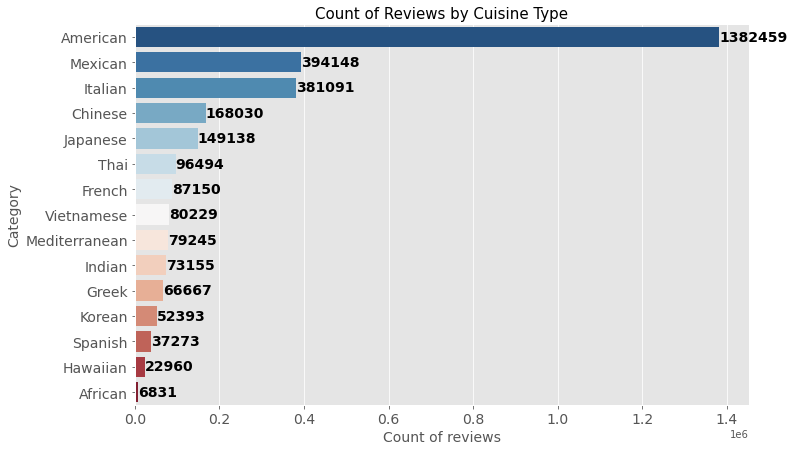

In [70]:


import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(11,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)